In [15]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import os 

# For Data PreProcessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.utils import to_categorical

# Old DBN Class
# from dbn.tensorflow import SupervisedDBNClassification

# Models used
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import BernoulliRBM

In [16]:
# Get Data from File
csv_filename = "qc aggregated data.csv"
df = pd.read_csv(csv_filename)

# Specify Input and Output from Data
input_columns = ["tempmax", "tempmin", "temp", "feelslikemax", "feelslikemin", "feelslike", "dew", "humidity", "windspeed"]
output_column = ["conditions"]
X = df[input_columns]
Y = df[output_column]

# Preprocess the data (Convert raw string conditions to numerical values, and split data)
X = X.to_numpy()
le = LabelEncoder()
Y = le.fit_transform(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
while (len(np.unique(Y_train)) != len(le.classes_)) or (len(np.unique(Y_test)) != len(le.classes_)):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Class mapping - used later for labelling
label_mapping = {x: y for x, y in zip(le.transform(le.classes_), le.classes_)}
lm = list(label_mapping.values())
lm = [x.replace(",", ",\n") for x in lm]



/home/codespace/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
learning_rate = 0.02
total_units = 800
total_epochs = 50
batch_size = 128

# RBM
rbm = BernoulliRBM(n_components=total_units, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=1)

# Random Forest
r_forest = RandomForestClassifier()

# ('rbm1', clone(rbm)),
model = Pipeline(steps=[('rbm1', clone(rbm)), ('rbm2', clone(rbm)), ('rfc', clone(r_forest))])
model.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = 0.00, time = 0.08s
[BernoulliRBM] Iteration 2, pseudo-likelihood = 0.00, time = 0.18s
[BernoulliRBM] Iteration 3, pseudo-likelihood = 0.00, time = 0.18s
[BernoulliRBM] Iteration 4, pseudo-likelihood = 0.00, time = 0.22s
[BernoulliRBM] Iteration 5, pseudo-likelihood = 0.00, time = 0.19s
[BernoulliRBM] Iteration 6, pseudo-likelihood = 0.00, time = 0.18s
[BernoulliRBM] Iteration 7, pseudo-likelihood = 0.00, time = 0.18s
[BernoulliRBM] Iteration 8, pseudo-likelihood = 0.00, time = 0.19s
[BernoulliRBM] Iteration 9, pseudo-likelihood = 0.00, time = 0.19s
[BernoulliRBM] Iteration 10, pseudo-likelihood = 0.00, time = 0.20s
[BernoulliRBM] Iteration 11, pseudo-likelihood = 0.00, time = 0.27s
[BernoulliRBM] Iteration 12, pseudo-likelihood = 0.00, time = 0.24s
[BernoulliRBM] Iteration 13, pseudo-likelihood = 0.00, time = 0.24s
[BernoulliRBM] Iteration 14, pseudo-likelihood = 0.00, time = 0.26s
[BernoulliRBM] Iteration 15, pseudo-likelihood = 0.00, ti

Pipeline(steps=[('rbm1',
                 BernoulliRBM(batch_size=128, learning_rate=0.02,
                              n_components=800, n_iter=50, verbose=1)),
                ('rbm2',
                 BernoulliRBM(batch_size=128, learning_rate=0.02,
                              n_components=800, n_iter=50, verbose=1)),
                ('rfc', RandomForestClassifier())])

# Results

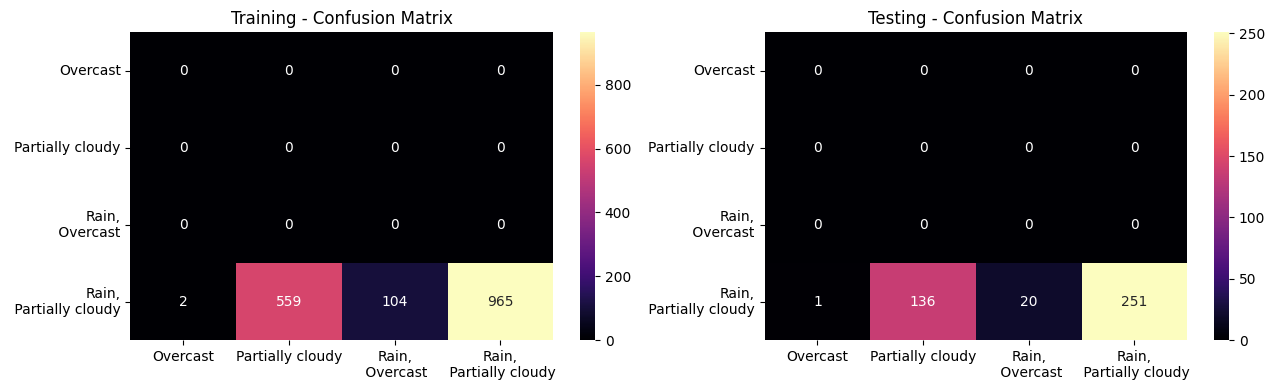

Testing: 0.6151960784313726 
Training: 0.5920245398773006


In [18]:
# Predict on training (for verification)
Y_pred_train = model.predict(X_train)
CM_train = confusion_matrix(Y_pred_train, Y_train)
train_acc = accuracy_score(Y_train, Y_pred_train)

# Testing Plot
plt.figure(figsize=(15, 4))
ax = plt.subplot(121)
ax.set_title("Training - Confusion Matrix")
sns.heatmap(CM_train, annot=True, cmap="magma", ax=ax, fmt='d')
ax.xaxis.set_ticklabels(lm)
ax.yaxis.set_ticklabels(lm)
plt.yticks(rotation=0)

# Predict on testing (for verification)
Y_pred_test = model.predict(X_test)
CM_test = confusion_matrix(Y_pred_test, Y_test)
test_acc = accuracy_score(Y_test, Y_pred_test)

ax2 = plt.subplot(122)
ax2.set_title("Testing - Confusion Matrix")
sns.heatmap(CM_test, annot=True, cmap="magma", ax=ax2, fmt='d')
ax2.xaxis.set_ticklabels(lm)
ax2.yaxis.set_ticklabels(lm)
plt.yticks(rotation=0)

plt.show()
print(f"Testing: {test_acc} \nTraining: {train_acc}")

In [19]:
np.unique(np.array(Y_pred_train)), np.unique(Y_train)

(array([3]), array([0, 1, 2, 3]))